In [4]:
import h5py as h5
import numpy as np
import glob

In [5]:
# print(filename)

In [6]:
files1 = glob.glob('/scratch/mdd423/CNN_EPRV/data/peg51_256/*.h5')
print(files1)
filename = files1[0]
ds = h5.File(filename,'r')

['/scratch/mdd423/CNN_EPRV/data/peg51_256/51Peg_0-256_1200-1456.h5']


In [7]:
import pickle

In [8]:
def save(filename,model):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)
def load(filename):
    with open(filename, 'rb') as input:  # Overwrites any existing file.
        model = pickle.load(input)
        return model

In [9]:
import os.path as path

In [10]:
filename

'/scratch/mdd423/CNN_EPRV/data/peg51_256/51Peg_0-256_1200-1456.h5'

In [11]:
diff = 16
size = 4096
size = 256
for j in range(17):
    print((j*size - j*diff),((j+1)*size - j*diff))

0 256
240 496
480 736
720 976
960 1216
1200 1456
1440 1696
1680 1936
1920 2176
2160 2416
2400 2656
2640 2896
2880 3136
3120 3376
3360 3616
3600 3856
3840 4096


In [18]:
def h5_to_array(ds,target,location,hdu_num='hdu_1'):
    rvs_stack = []
    bcs_stack = []
    tim_stack = []
    
    img_stack = np.empty((0,3,256,256))
    for visit_name,vist_info in ds['visits'].items():
#         for hdu_num in ds['images'][visit_name].keys():
        img   = np.array(ds['images'][visit_name][hdu_num])
#         
        if np.sum(img.shape) == (256*2):
            rvs_stack += [np.double(vist_info.attrs['ESO DRS CCF RVC'])]
            temp_time = at.Time(visit_name.split('HARPS.')[1])
            tim_stack += [temp_time]
            bcs_stack += [target.radial_velocity_correction(obstime=temp_time, location=location).to('km/s').value]
            all_flats = np.empty([0,256,256])
            for key in vist_info.attrs.keys():
                if vist_info.attrs[key] == 'FLAT':
                    temp = np.array(ds['images'][key][hdu_num])[None,...]
                    all_flats = np.append(all_flats, temp,axis=0)
                if vist_info.attrs[key] == 'THAR_THAR':
                    cali = np.array(ds['images'][key][hdu_num])
#                 temp = crop_again(np.stack((img,np.median(all_flats,axis=0),cali)))
            temp = np.stack((img,np.median(all_flats,axis=0),cali))[None,...]
#                 print(temp.shape)
            img_stack = np.append(img_stack,temp,axis=0)
    return img_stack, np.array(rvs_stack), np.array(bcs_stack), np.array(tim_stack)

In [19]:
import astropy.coordinates as coords
import astropy.time as at

target.radial_velocity_correction(obstime=obstime, location=keck).to('km/s')

In [20]:
filename

'/scratch/mdd423/CNN_EPRV/data/peg51_256/51Peg_0-256_1200-1456.h5'

In [21]:
location = coords.EarthLocation.of_site('La Silla Observatory')
target   = coords.SkyCoord.from_name('51PEG')
img_stack, rvs_stack, bcs_stack, tim_stack = h5_to_array(ds,target,location,hdu_num='hdu_1')

In [22]:
tim_stack.shape

(311,)

In [23]:
dir_name, tailname = path.split(filename)
tailname = tailname[:-3]
imgname = path.join(dir_name, tailname + '_img.nda')
rvsname = path.join(dir_name, tailname + '_rvs.nda')
bcsname = path.join(dir_name, tailname + '_bcs.nda')
timname = path.join(dir_name, tailname + '_tim.nda')
# print(imgname,rvsname)
save(imgname,img_stack)
save(rvsname,rvs_stack)
save(bcsname,bcs_stack)
save(timname,tim_stack)
img_stack = load(imgname)
rvs_stack = load(rvsname)
bcs_stack = load(bcsname)
tim_stack = load(timname)

In [16]:
import matplotlib.pyplot as plt

In [17]:
from tqdm import tqdm
import matplotlib.pyplot as plt

<h2>Movie Making</h2>
we are going to make some gifs of the data to visiual changes. start by initializing the plot to be produced

<h3>Gif generating workhorse</h3>
loop through function the changes the plot data

In [18]:
import matplotlib.animation as animation

In [19]:
import subprocess
subprocess.run('ffmpeg')

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu

CompletedProcess(args='ffmpeg', returncode=1)

In [20]:
%matplotlib notebook

In [21]:
orders = np.argsort(tim_stack)

<IPython.core.display.Javascript object>


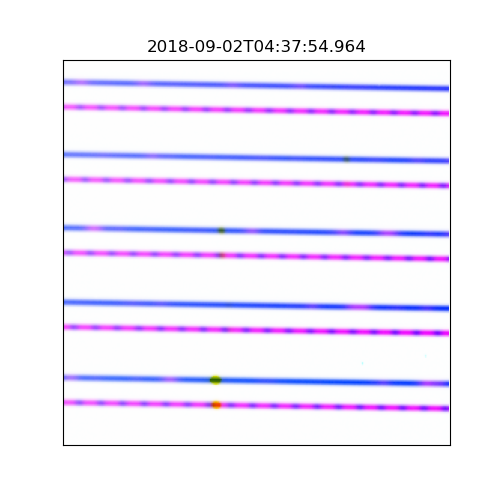

312it [00:10, 30.62it/s]                         


In [23]:
fig, ax = plt.subplots(figsize=(5, 5))

temp    = np.swapaxes(img_stack[0,:,...],0,-1).copy()
# print(temp.shape)
for k in range(3):
    temp[...,k]  = np.swapaxes(img_stack[0,k,...],0,-1)
    temp[...,k] -= np.min(temp[...,k])
    temp[...,k] /= np.max(temp[...,k])


axesimg = ax.imshow(1-temp)
ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("BERV = {}".format(bcs_stack[0]))

N = len(rvs_stack)
index_range = np.arange(N,dtype=int)
with tqdm(total=N) as pbar:
        
    def next_image(index):
#         temp    = np.swapaxes(img_stack[index,:,...],0,-1).copy()
        # print(temp.shape)
        for k in range(3):
            temp[...,k]  = np.swapaxes(img_stack[index,k,...],0,-1)
            temp[...,k] -= np.min(temp[...,k])
            temp[...,k] /= np.max(temp[...,k])
        
        axesimg.set(data = (1-temp))
        ax.set_title("{}".format(tim_stack[index]))
        pbar.update(1)
        
        return axesimg,
            
    ani = animation.FuncAnimation(
        fig,
        next_image,
        frames=orders,
        interval=3,
        repeat=False,
        repeat_delay=1000,
        blit=True
    )
#     plt.show()

    ani.save(
        "/scratch/mdd423/CNN_EPRV/{}_hdu_1_time.gif".format(tailname)
    )

(526, 526, 3)


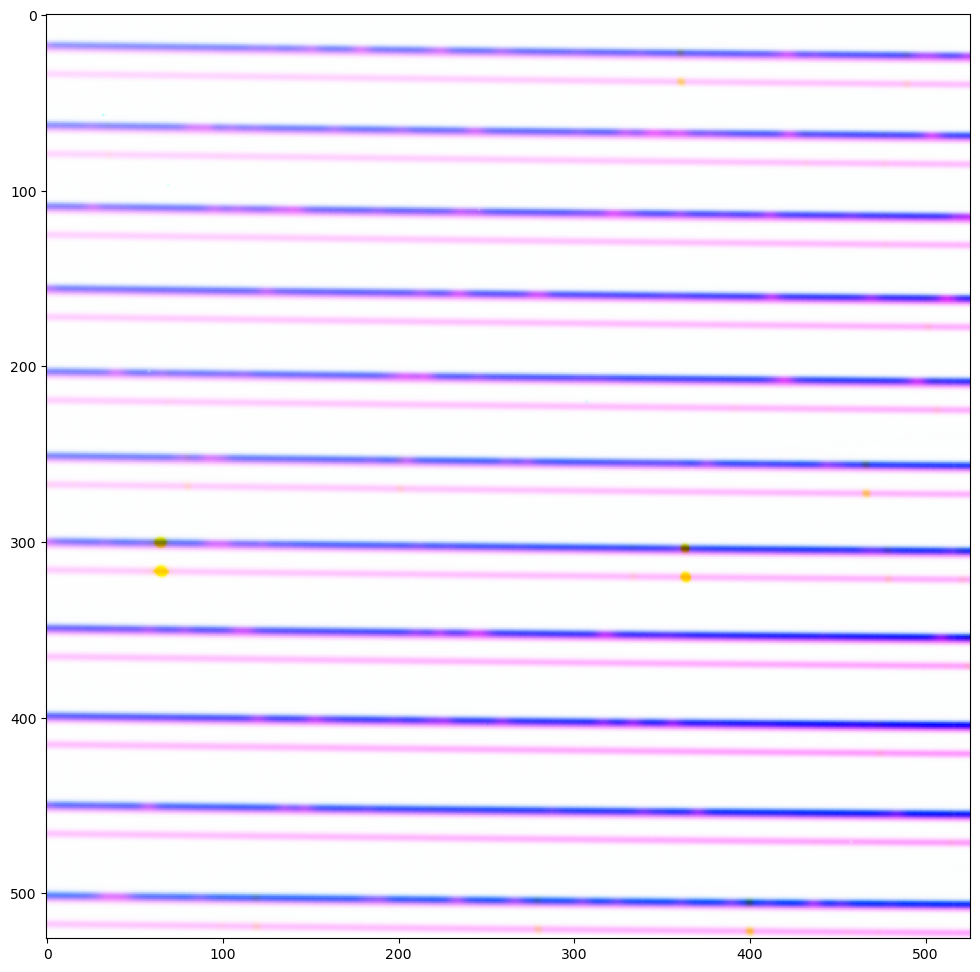

In [50]:
nnn = 1
fig, axs = plt.subplots(nnn,figsize=(5,5))
for i in range(nnn):
#     for j in range(3):
    temp    = np.swapaxes(img_stack[i,:,...],0,-1).copy()
    print(temp.shape)
    for k in range(3):
        temp[...,k] = np.swapaxes(img_stack[i,k,...],0,-1)
        temp[...,k] -= np.min(temp[...,k])
        temp[...,k] /= np.max(temp[...,k])
#     temp[2] = np.swapaxes(img_stack[i,2,...],0,-1)- np.min()/(np.max(img_stack[i,2,...]) - np.min(img_stack[i,2,...]))
#     temp[1] = np.swapaxes(img_stack[i,1,...],0,-1)/(np.max(img_stack[i,1,...]) - np.min(img_stack[i,1,...]))
    axs.imshow(1-temp)
plt.show()

In [8]:
def scan_hdf5(path, recursive=True, tab_step=2):
    def scan_node(g, tabs=0):
        print(' ' * tabs, g.name)
        for k, v in g.items():
            if isinstance(v, h5.Dataset):
                print(k,np.array(v).shape)
#                 print(' ' * tabs + ' ' * tab_step + ' -', v.name)
            elif isinstance(v, h5.Group) and recursive:
                scan_node(v, tabs=tabs + tab_step)
    with h5.File(path, 'r') as f:
        scan_node(f)

In [17]:
scan_hdf5(filename, recursive=True, tab_step=2)

 /
   /images
     /images/HARPS.2013-06-07T21:09:49.773
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2013-06-07T21:22:04.297
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2013-06-07T21:23:44.983
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2013-06-07T21:25:25.959
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2013-06-07T21:27:05.955
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2013-06-07T21:28:46.121
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2013-06-08T08:04:03.052
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2013-06-08T08:11:35.239
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2013-06-08T08:19:06.826
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2013-06-08T19:21:05.076
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2013-06-08T19:21:45.259
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS

hdu_2 (526, 526)
     /images/HARPS.2013-09-08T19:11:13.393
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2013-09-08T19:11:53.106
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2013-09-08T19:12:33.138
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2013-09-08T19:13:13.120
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2013-09-08T19:13:52.123
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2013-09-08T19:28:29.935
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2013-09-08T20:02:07.746
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2013-09-08T20:02:43.488
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2013-09-08T20:03:19.510
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2013-09-08T20:03:55.573
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2013-09-08T20:04:31.505
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HA

hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-06-05T09:15:49.978
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-06-05T09:26:21.002
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-06-05T09:36:51.967
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-06-05T09:47:22.982
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-06-05T09:57:54.046
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-06-05T10:52:35.395
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-06-05T10:53:30.758
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-06-05T10:54:26.761
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-06-05T10:55:22.914
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-06-05T10:56:18.767
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-06-05T10:57:14.800
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526

hdu_2 (526, 526)
     /images/HARPS.2018-07-08T20:39:11.790
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-07-08T20:40:07.283
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-07-08T20:41:02.907
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-07-08T20:41:58.359
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-07-08T20:42:53.902
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-07-08T20:43:49.316
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-07-08T20:44:44.938
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-07-08T20:45:40.372
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-07-08T20:46:35.874
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-07-08T20:47:31.288
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-07-08T20:48:26.840
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HA

hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-07-09T17:15:02.834
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-07-09T20:03:17.819
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-07-09T20:06:21.408
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-07-14T06:27:58.385
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-07-14T06:33:29.222
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-07-14T06:38:59.930
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-07-14T06:44:31.818
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-07-14T06:50:02.586
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-07-14T06:55:33.404
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-07-14T07:01:05.061
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-07-14T07:06:36.049
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526

hdu_2 (526, 526)
     /images/HARPS.2018-08-12T10:32:02.259
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-08-12T10:32:58.252
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-08-12T10:33:54.245
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-08-12T10:34:50.288
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-08-12T10:35:46.261
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-08-12T10:36:42.274
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-08-12T10:37:38.787
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-08-12T10:38:34.261
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-08-12T10:39:30.253
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-08-12T10:40:26.257
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-08-12T10:41:22.250
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HA

hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-08-17T11:43:45.520
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-08-21T03:36:12.765
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-08-21T03:41:43.783
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-08-21T03:47:14.791
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-08-21T03:52:46.699
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-08-21T03:58:17.757
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-08-21T04:03:48.735
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-08-21T04:09:19.723
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-08-21T04:14:50.721
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-08-21T04:20:21.699
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-08-21T04:25:52.766
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526

hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-09-02T10:12:51.709
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-09-02T10:13:47.702
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-09-02T10:14:43.715
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-09-02T10:15:39.868
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-09-02T10:16:35.731
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-09-02T10:17:31.734
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-09-02T10:18:27.707
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-09-02T10:19:23.710
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-09-02T10:20:19.693
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-09-02T10:21:15.696
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526)
     /images/HARPS.2018-09-02T10:22:11.709
hdu_0 (0,)
hdu_1 (526, 526)
hdu_2 (526, 526

In [11]:
arr = []
for x,v in ds['visits'].items():
    ele = len(v.attrs.keys())
    if not ele in np.unique(arr):
        print('\n' + x + ' : '+str(ele))
        for key in v.attrs.keys():
            print(key,v.attrs[key])
    arr.append(ele)


HARPS.2013-06-08T08:04:03.052 : 13
ESO DRS CCF RVC -33.1460221100532
ESO DRS DVRMS 0.279426395955705
HARPS.2013-06-07T21:09:49.773 THAR_THAR
HARPS.2013-06-07T21:22:04.297 FLAT
HARPS.2013-06-07T21:23:44.983 FLAT
HARPS.2013-06-07T21:25:25.959 FLAT
HARPS.2013-06-07T21:27:05.955 FLAT
HARPS.2013-06-07T21:28:46.121 FLAT
HARPS.2013-06-08T19:21:05.076 FLAT
HARPS.2013-06-08T19:21:45.259 FLAT
HARPS.2013-06-08T19:22:25.241 FLAT
HARPS.2013-06-08T19:23:05.163 FLAT
HARPS.2013-06-08T19:23:45.196 FLAT

HARPS.2013-06-25T06:50:16.144 : 8
ESO DRS CCF RVC -50.5280303909004
ESO DRS DVRMS 6.85651529156134
HARPS.2013-06-24T19:50:15.122 FLAT
HARPS.2013-06-24T19:50:54.804 FLAT
HARPS.2013-06-24T19:51:33.837 FLAT
HARPS.2013-06-24T19:52:13.839 FLAT
HARPS.2013-06-24T19:52:52.871 FLAT
HARPS.2013-06-24T21:23:15.021 THAR_THAR

HARPS.2018-06-05T08:33:43.971 : 24
ESO DRS CCF RVC -33.1679433185544
ESO DRS DVRMS 0.229544492977142
HARPS.2018-06-04T21:55:36.510 THAR_THAR
HARPS.2018-06-04T21:58:46.291 THAR_FP
HARPS.2018-06

In [130]:
np.unique(arr)

array([  8,   9,  13,  24, 104])

In [134]:
len(arr)

311

In [135]:
for x in np.unique(arr):
    print(x,' : ',np.sum(np.array(arr) == x))

8  :  28
9  :  76
13  :  65
24  :  141
104  :  1


In [37]:
import numpy as np

In [60]:
print(np.unique(arr))

[  8   9  13  24 104]


In [142]:
for x in ds['visits']['HARPS.2013-06-08T08:04:03.052'].items():
    print(x)

In [61]:
ds['visits']['HARPS.2013-06-08T08:04:03.052'].attrs['HARPS.2013-06-07T21:09:49.773'],ds['visits']['HARPS.2013-06-08T08:04:03.052'].attrs['HARPS.2013-06-07T21:22:04.297']

('THAR_THAR', 'FLAT')

In [59]:
ds['images']['HARPS.2013-06-08T08:04:03.052'], ds['images']['HARPS.2013-06-07T21:09:49.773'], ds['images']['HARPS.2013-06-07T21:22:04.297'],

(<HDF5 group "/images/HARPS.2013-06-08T08:04:03.052" (3 members)>,
 <HDF5 group "/images/HARPS.2013-06-07T21:09:49.773" (3 members)>,
 <HDF5 group "/images/HARPS.2013-06-07T21:22:04.297" (3 members)>)

In [62]:
ref_arr = ['HARPS.2013-06-08T08:04:03.052','HARPS.2013-06-07T21:09:49.773','HARPS.2013-06-07T21:22:04.297']

In [9]:
import matplotlib.pyplot as plt

In [10]:
for r_key in ref_arr:
    print(ds['images'][r_key]['hdu_2'].shape)
    np_arr = np.array(ds['images'][r_key]['hdu_1'])
    plt.imshow(np_arr)
    plt.show()

NameError: name 'ref_arr' is not defined

In [75]:
print(len(ds['visits']))

311


In [21]:
ref_arr = []
for i,x_packet in enumerate(ds['visits'].items()):
    ref_arr.append(['','',''])
    x,v = x_packet
    ref_arr[i][0] = x
    flat_bool = False
    cali_bool = False
    for key in v.attrs.keys():
        print(x,key)
        if v.attrs[key] == 'FLAT' and not flat_bool:
            ref_arr[i][1] = key
            flat_bool = True
#             print(key)
        if v.attrs[key] == 'THAR_THAR' and not cali_bool:
            ref_arr[i][2] = key
            cali_bool = True
#             print(key)
    if (not cali_bool) or (not flat_bool):
        print(' HEY HEYYYYYY HEYYYYYYYYYY')

HARPS.2013-06-08T08:04:03.052 ESO DRS CCF RVC
HARPS.2013-06-08T08:04:03.052 ESO DRS DVRMS
HARPS.2013-06-08T08:04:03.052 HARPS.2013-06-07T21:09:49.773
HARPS.2013-06-08T08:04:03.052 HARPS.2013-06-07T21:22:04.297
HARPS.2013-06-08T08:04:03.052 HARPS.2013-06-07T21:23:44.983
HARPS.2013-06-08T08:04:03.052 HARPS.2013-06-07T21:25:25.959
HARPS.2013-06-08T08:04:03.052 HARPS.2013-06-07T21:27:05.955
HARPS.2013-06-08T08:04:03.052 HARPS.2013-06-07T21:28:46.121
HARPS.2013-06-08T08:04:03.052 HARPS.2013-06-08T19:21:05.076
HARPS.2013-06-08T08:04:03.052 HARPS.2013-06-08T19:21:45.259
HARPS.2013-06-08T08:04:03.052 HARPS.2013-06-08T19:22:25.241
HARPS.2013-06-08T08:04:03.052 HARPS.2013-06-08T19:23:05.163
HARPS.2013-06-08T08:04:03.052 HARPS.2013-06-08T19:23:45.196
HARPS.2013-06-08T08:11:35.239 ESO DRS CCF RVC
HARPS.2013-06-08T08:11:35.239 ESO DRS DVRMS
HARPS.2013-06-08T08:11:35.239 HARPS.2013-06-07T21:09:49.773
HARPS.2013-06-08T08:11:35.239 HARPS.2013-06-07T21:22:04.297
HARPS.2013-06-08T08:11:35.239 HARPS.2013

HARPS.2013-09-05T04:06:57.868 HARPS.2013-09-04T20:39:37.106
HARPS.2013-09-05T04:06:57.868 HARPS.2013-09-04T20:40:17.148
HARPS.2013-09-05T04:06:57.868 HARPS.2013-09-04T20:40:57.121
HARPS.2013-09-05T04:06:57.868 HARPS.2013-09-04T20:41:37.133
HARPS.2013-09-05T04:06:57.868 HARPS.2013-09-04T20:44:13.942
HARPS.2013-09-05T04:06:57.868 HARPS.2013-09-04T21:01:26.794
HARPS.2013-09-05T04:06:57.868 HARPS.2013-09-04T21:02:02.636
HARPS.2013-09-05T04:06:57.868 HARPS.2013-09-04T21:02:38.498
HARPS.2013-09-05T04:06:57.868 HARPS.2013-09-04T21:03:14.500
HARPS.2013-09-05T04:06:57.868 HARPS.2013-09-04T21:03:50.532
HARPS.2013-09-05T04:17:30.365 ESO DRS CCF RVC
HARPS.2013-09-05T04:17:30.365 ESO DRS DVRMS
HARPS.2013-09-05T04:17:30.365 HARPS.2013-09-04T20:38:57.403
HARPS.2013-09-05T04:17:30.365 HARPS.2013-09-04T20:39:37.106
HARPS.2013-09-05T04:17:30.365 HARPS.2013-09-04T20:40:17.148
HARPS.2013-09-05T04:17:30.365 HARPS.2013-09-04T20:40:57.121
HARPS.2013-09-05T04:17:30.365 HARPS.2013-09-04T20:41:37.133
HARPS.2013

HARPS.2013-09-30T00:48:49.783 HARPS.2013-09-29T19:36:53.808
HARPS.2013-09-30T00:48:49.783 HARPS.2013-09-29T19:37:33.901
HARPS.2013-09-30T00:48:49.783 HARPS.2013-09-29T19:40:13.181
HARPS.2013-09-30T00:48:49.783 HARPS.2013-09-29T20:42:51.714
HARPS.2013-09-30T00:48:49.783 HARPS.2013-09-29T20:43:28.014
HARPS.2013-09-30T00:48:49.783 HARPS.2013-09-29T20:44:03.788
HARPS.2013-09-30T00:48:49.783 HARPS.2013-09-29T20:44:39.730
HARPS.2013-09-30T00:48:49.783 HARPS.2013-09-29T20:45:15.792
HARPS.2013-09-30T00:57:02.053 ESO DRS CCF RVC
HARPS.2013-09-30T00:57:02.053 ESO DRS DVRMS
HARPS.2013-09-30T00:57:02.053 HARPS.2013-09-29T19:34:53.912
HARPS.2013-09-30T00:57:02.053 HARPS.2013-09-29T19:35:33.343
HARPS.2013-09-30T00:57:02.053 HARPS.2013-09-29T19:36:13.796
HARPS.2013-09-30T00:57:02.053 HARPS.2013-09-29T19:36:53.808
HARPS.2013-09-30T00:57:02.053 HARPS.2013-09-29T19:37:33.901
HARPS.2013-09-30T00:57:02.053 HARPS.2013-09-29T19:40:13.181
HARPS.2013-09-30T00:57:02.053 HARPS.2013-09-29T20:42:51.714
HARPS.2013

HARPS.2013-09-30T03:21:40.421 HARPS.2013-09-29T20:42:51.714
HARPS.2013-09-30T03:21:40.421 HARPS.2013-09-29T20:43:28.014
HARPS.2013-09-30T03:21:40.421 HARPS.2013-09-29T20:44:03.788
HARPS.2013-09-30T03:21:40.421 HARPS.2013-09-29T20:44:39.730
HARPS.2013-09-30T03:21:40.421 HARPS.2013-09-29T20:45:15.792
HARPS.2013-09-30T03:29:42.420 ESO DRS CCF RVC
HARPS.2013-09-30T03:29:42.420 ESO DRS DVRMS
HARPS.2013-09-30T03:29:42.420 HARPS.2013-09-29T19:34:53.912
HARPS.2013-09-30T03:29:42.420 HARPS.2013-09-29T19:35:33.343
HARPS.2013-09-30T03:29:42.420 HARPS.2013-09-29T19:36:13.796
HARPS.2013-09-30T03:29:42.420 HARPS.2013-09-29T19:36:53.808
HARPS.2013-09-30T03:29:42.420 HARPS.2013-09-29T19:37:33.901
HARPS.2013-09-30T03:29:42.420 HARPS.2013-09-29T19:40:13.181
HARPS.2013-09-30T03:29:42.420 HARPS.2013-09-29T20:42:51.714
HARPS.2013-09-30T03:29:42.420 HARPS.2013-09-29T20:43:28.014
HARPS.2013-09-30T03:29:42.420 HARPS.2013-09-29T20:44:03.788
HARPS.2013-09-30T03:29:42.420 HARPS.2013-09-29T20:44:39.730
HARPS.2013

HARPS.2018-06-05T08:54:47.025 ESO DRS CCF RVC
HARPS.2018-06-05T08:54:47.025 ESO DRS DVRMS
HARPS.2018-06-05T08:54:47.025 HARPS.2018-06-04T21:55:36.510
HARPS.2018-06-05T08:54:47.025 HARPS.2018-06-04T21:58:46.291
HARPS.2018-06-05T08:54:47.025 HARPS.2018-06-05T10:52:35.395
HARPS.2018-06-05T08:54:47.025 HARPS.2018-06-05T10:53:30.758
HARPS.2018-06-05T08:54:47.025 HARPS.2018-06-05T10:54:26.761
HARPS.2018-06-05T08:54:47.025 HARPS.2018-06-05T10:55:22.914
HARPS.2018-06-05T08:54:47.025 HARPS.2018-06-05T10:56:18.767
HARPS.2018-06-05T08:54:47.025 HARPS.2018-06-05T10:57:14.800
HARPS.2018-06-05T08:54:47.025 HARPS.2018-06-05T10:58:10.763
HARPS.2018-06-05T08:54:47.025 HARPS.2018-06-05T10:59:06.757
HARPS.2018-06-05T08:54:47.025 HARPS.2018-06-05T11:00:03.830
HARPS.2018-06-05T08:54:47.025 HARPS.2018-06-05T11:00:59.763
HARPS.2018-06-05T08:54:47.025 HARPS.2018-06-05T11:01:55.745
HARPS.2018-06-05T08:54:47.025 HARPS.2018-06-05T11:02:51.778
HARPS.2018-06-05T08:54:47.025 HARPS.2018-06-05T11:03:47.761
HARPS.2018

HARPS.2018-06-21T08:27:20.617 ESO DRS DVRMS
HARPS.2018-06-21T08:27:20.617 HARPS.2018-06-20T20:20:24.251
HARPS.2018-06-21T08:27:20.617 HARPS.2018-06-20T20:23:33.262
HARPS.2018-06-21T08:27:20.617 HARPS.2018-06-21T10:40:19.332
HARPS.2018-06-21T08:27:20.617 HARPS.2018-06-21T10:41:15.466
HARPS.2018-06-21T08:27:20.617 HARPS.2018-06-21T10:42:11.489
HARPS.2018-06-21T08:27:20.617 HARPS.2018-06-21T10:43:07.512
HARPS.2018-06-21T08:27:20.617 HARPS.2018-06-21T10:44:03.465
HARPS.2018-06-21T08:27:20.617 HARPS.2018-06-21T10:44:59.528
HARPS.2018-06-21T08:27:20.617 HARPS.2018-06-21T10:45:55.451
HARPS.2018-06-21T08:27:20.617 HARPS.2018-06-21T10:46:51.444
HARPS.2018-06-21T08:27:20.617 HARPS.2018-06-21T10:47:47.447
HARPS.2018-06-21T08:27:20.617 HARPS.2018-06-21T10:48:43.550
HARPS.2018-06-21T08:27:20.617 HARPS.2018-06-21T10:49:39.523
HARPS.2018-06-21T08:27:20.617 HARPS.2018-06-21T10:50:35.497
HARPS.2018-06-21T08:27:20.617 HARPS.2018-06-21T10:51:31.460
HARPS.2018-06-21T08:27:20.617 HARPS.2018-06-21T10:52:27.

HARPS.2018-06-21T09:30:28.454 HARPS.2018-06-21T10:53:23.445
HARPS.2018-06-21T09:30:28.454 HARPS.2018-06-21T10:54:19.528
HARPS.2018-06-21T09:30:28.454 HARPS.2018-06-21T10:55:15.491
HARPS.2018-06-21T09:30:28.454 HARPS.2018-06-21T10:56:11.465
HARPS.2018-06-21T09:30:28.454 HARPS.2018-06-21T10:57:07.528
HARPS.2018-06-21T09:30:28.454 HARPS.2018-06-21T10:58:03.450
HARPS.2018-06-21T09:30:28.454 HARPS.2018-06-21T20:53:20.255
HARPS.2018-06-21T09:30:28.454 HARPS.2018-06-21T20:56:24.467
HARPS.2018-06-21T09:38:29.570 ESO DRS CCF RVC
HARPS.2018-06-21T09:38:29.570 ESO DRS DVRMS
HARPS.2018-06-21T09:38:29.570 HARPS.2018-06-21T10:40:19.332
HARPS.2018-06-21T09:38:29.570 HARPS.2018-06-21T10:41:15.466
HARPS.2018-06-21T09:38:29.570 HARPS.2018-06-21T10:42:11.489
HARPS.2018-06-21T09:38:29.570 HARPS.2018-06-21T10:43:07.512
HARPS.2018-06-21T09:38:29.570 HARPS.2018-06-21T10:44:03.465
HARPS.2018-06-21T09:38:29.570 HARPS.2018-06-21T10:44:59.528
HARPS.2018-06-21T09:38:29.570 HARPS.2018-06-21T10:45:55.451
HARPS.2018

HARPS.2018-07-09T06:43:14.408 HARPS.2018-07-08T21:22:43.242
HARPS.2018-07-09T06:43:14.408 HARPS.2018-07-08T21:23:38.695
HARPS.2018-07-09T06:43:14.408 HARPS.2018-07-08T21:24:34.258
HARPS.2018-07-09T06:43:14.408 HARPS.2018-07-08T21:25:29.571
HARPS.2018-07-09T06:43:14.408 HARPS.2018-07-08T21:26:25.014
HARPS.2018-07-09T06:43:14.408 HARPS.2018-07-08T21:27:20.387
HARPS.2018-07-09T06:43:14.408 HARPS.2018-07-08T21:28:16.120
HARPS.2018-07-09T06:43:14.408 HARPS.2018-07-08T21:29:11.713
HARPS.2018-07-09T06:43:14.408 HARPS.2018-07-08T21:30:07.186
HARPS.2018-07-09T06:43:14.408 HARPS.2018-07-08T21:31:02.299
HARPS.2018-07-09T06:43:14.408 HARPS.2018-07-08T21:31:57.812
HARPS.2018-07-09T06:43:14.408 HARPS.2018-07-08T21:32:53.275
HARPS.2018-07-09T06:43:14.408 HARPS.2018-07-08T21:33:48.888
HARPS.2018-07-09T06:43:14.408 HARPS.2018-07-08T21:34:44.311
HARPS.2018-07-09T06:43:14.408 HARPS.2018-07-08T21:35:39.964
HARPS.2018-07-09T06:43:14.408 HARPS.2018-07-08T21:36:35.367
HARPS.2018-07-09T06:43:14.408 HARPS.2018

HARPS.2018-07-14T06:50:02.586 HARPS.2018-07-14T11:18:55.724
HARPS.2018-07-14T06:50:02.586 HARPS.2018-07-14T11:19:52.367
HARPS.2018-07-14T06:50:02.586 HARPS.2018-07-14T11:20:47.871
HARPS.2018-07-14T06:50:02.586 HARPS.2018-07-14T11:21:43.383
HARPS.2018-07-14T06:50:02.586 HARPS.2018-07-14T11:22:39.016
HARPS.2018-07-14T06:50:02.586 HARPS.2018-07-14T14:17:49.893
HARPS.2018-07-14T06:50:02.586 HARPS.2018-07-14T14:23:09.430
HARPS.2018-07-14T06:55:33.404 ESO DRS CCF RVC
HARPS.2018-07-14T06:55:33.404 ESO DRS DVRMS
HARPS.2018-07-14T06:55:33.404 HARPS.2018-07-14T11:05:02.770
HARPS.2018-07-14T06:55:33.404 HARPS.2018-07-14T11:05:58.282
HARPS.2018-07-14T06:55:33.404 HARPS.2018-07-14T11:06:53.786
HARPS.2018-07-14T06:55:33.404 HARPS.2018-07-14T11:07:49.338
HARPS.2018-07-14T06:55:33.404 HARPS.2018-07-14T11:08:44.971
HARPS.2018-07-14T06:55:33.404 HARPS.2018-07-14T11:09:40.584
HARPS.2018-07-14T06:55:33.404 HARPS.2018-07-14T11:10:35.747
HARPS.2018-07-14T06:55:33.404 HARPS.2018-07-14T11:11:31.420
HARPS.2018

HARPS.2018-07-14T07:50:46.112 HARPS.2018-07-14T11:06:53.786
HARPS.2018-07-14T07:50:46.112 HARPS.2018-07-14T11:07:49.338
HARPS.2018-07-14T07:50:46.112 HARPS.2018-07-14T11:08:44.971
HARPS.2018-07-14T07:50:46.112 HARPS.2018-07-14T11:09:40.584
HARPS.2018-07-14T07:50:46.112 HARPS.2018-07-14T11:10:35.747
HARPS.2018-07-14T07:50:46.112 HARPS.2018-07-14T11:11:31.420
HARPS.2018-07-14T07:50:46.112 HARPS.2018-07-14T11:12:27.043
HARPS.2018-07-14T07:50:46.112 HARPS.2018-07-14T11:13:22.576
HARPS.2018-07-14T07:50:46.112 HARPS.2018-07-14T11:14:18.150
HARPS.2018-07-14T07:50:46.112 HARPS.2018-07-14T11:15:13.713
HARPS.2018-07-14T07:50:46.112 HARPS.2018-07-14T11:16:09.295
HARPS.2018-07-14T07:50:46.112 HARPS.2018-07-14T11:17:04.648
HARPS.2018-07-14T07:50:46.112 HARPS.2018-07-14T11:18:00.141
HARPS.2018-07-14T07:50:46.112 HARPS.2018-07-14T11:18:55.724
HARPS.2018-07-14T07:50:46.112 HARPS.2018-07-14T11:19:52.367
HARPS.2018-07-14T07:50:46.112 HARPS.2018-07-14T11:20:47.871
HARPS.2018-07-14T07:50:46.112 HARPS.2018

HARPS.2018-07-14T09:22:54.030 HARPS.2018-07-14T11:21:43.383
HARPS.2018-07-14T09:22:54.030 HARPS.2018-07-14T11:22:39.016
HARPS.2018-07-14T09:22:54.030 HARPS.2018-07-14T14:17:49.893
HARPS.2018-07-14T09:22:54.030 HARPS.2018-07-14T14:23:09.430
HARPS.2018-07-14T09:28:24.788 ESO DRS CCF RVC
HARPS.2018-07-14T09:28:24.788 ESO DRS DVRMS
HARPS.2018-07-14T09:28:24.788 HARPS.2018-07-14T11:05:02.770
HARPS.2018-07-14T09:28:24.788 HARPS.2018-07-14T11:05:58.282
HARPS.2018-07-14T09:28:24.788 HARPS.2018-07-14T11:06:53.786
HARPS.2018-07-14T09:28:24.788 HARPS.2018-07-14T11:07:49.338
HARPS.2018-07-14T09:28:24.788 HARPS.2018-07-14T11:08:44.971
HARPS.2018-07-14T09:28:24.788 HARPS.2018-07-14T11:09:40.584
HARPS.2018-07-14T09:28:24.788 HARPS.2018-07-14T11:10:35.747
HARPS.2018-07-14T09:28:24.788 HARPS.2018-07-14T11:11:31.420
HARPS.2018-07-14T09:28:24.788 HARPS.2018-07-14T11:12:27.043
HARPS.2018-07-14T09:28:24.788 HARPS.2018-07-14T11:13:22.576
HARPS.2018-07-14T09:28:24.788 HARPS.2018-07-14T11:14:18.150
HARPS.2018

HARPS.2018-07-14T10:08:22.917 HARPS.2018-07-14T11:08:44.971
HARPS.2018-07-14T10:08:22.917 HARPS.2018-07-14T11:09:40.584
HARPS.2018-07-14T10:08:22.917 HARPS.2018-07-14T11:10:35.747
HARPS.2018-07-14T10:08:22.917 HARPS.2018-07-14T11:11:31.420
HARPS.2018-07-14T10:08:22.917 HARPS.2018-07-14T11:12:27.043
HARPS.2018-07-14T10:08:22.917 HARPS.2018-07-14T11:13:22.576
HARPS.2018-07-14T10:08:22.917 HARPS.2018-07-14T11:14:18.150
HARPS.2018-07-14T10:08:22.917 HARPS.2018-07-14T11:15:13.713
HARPS.2018-07-14T10:08:22.917 HARPS.2018-07-14T11:16:09.295
HARPS.2018-07-14T10:08:22.917 HARPS.2018-07-14T11:17:04.648
HARPS.2018-07-14T10:08:22.917 HARPS.2018-07-14T11:18:00.141
HARPS.2018-07-14T10:08:22.917 HARPS.2018-07-14T11:18:55.724
HARPS.2018-07-14T10:08:22.917 HARPS.2018-07-14T11:19:52.367
HARPS.2018-07-14T10:08:22.917 HARPS.2018-07-14T11:20:47.871
HARPS.2018-07-14T10:08:22.917 HARPS.2018-07-14T11:21:43.383
HARPS.2018-07-14T10:08:22.917 HARPS.2018-07-14T11:22:39.016
HARPS.2018-07-14T10:08:22.917 HARPS.2018

HARPS.2018-08-12T05:10:45.473 HARPS.2018-08-12T10:29:14.240
HARPS.2018-08-12T05:10:45.473 HARPS.2018-08-12T10:30:10.263
HARPS.2018-08-12T05:10:45.473 HARPS.2018-08-12T10:31:06.236
HARPS.2018-08-12T05:10:45.473 HARPS.2018-08-12T10:32:02.259
HARPS.2018-08-12T05:10:45.473 HARPS.2018-08-12T10:32:58.252
HARPS.2018-08-12T05:10:45.473 HARPS.2018-08-12T10:33:54.245
HARPS.2018-08-12T05:10:45.473 HARPS.2018-08-12T10:34:50.288
HARPS.2018-08-12T05:10:45.473 HARPS.2018-08-12T10:35:46.261
HARPS.2018-08-12T05:10:45.473 HARPS.2018-08-12T10:36:42.274
HARPS.2018-08-12T05:10:45.473 HARPS.2018-08-12T10:37:38.787
HARPS.2018-08-12T05:10:45.473 HARPS.2018-08-12T10:38:34.261
HARPS.2018-08-12T05:10:45.473 HARPS.2018-08-12T10:39:30.253
HARPS.2018-08-12T05:10:45.473 HARPS.2018-08-12T10:40:26.257
HARPS.2018-08-12T05:10:45.473 HARPS.2018-08-12T10:41:22.250
HARPS.2018-08-12T05:21:16.466 ESO DRS CCF RVC
HARPS.2018-08-12T05:21:16.466 ESO DRS DVRMS
HARPS.2018-08-12T05:21:16.466 HARPS.2018-08-11T19:38:20.357
HARPS.2018

HARPS.2018-08-12T06:24:22.519 HARPS.2018-08-12T10:40:26.257
HARPS.2018-08-12T06:24:22.519 HARPS.2018-08-12T10:41:22.250
HARPS.2018-08-12T06:34:53.533 ESO DRS CCF RVC
HARPS.2018-08-12T06:34:53.533 ESO DRS DVRMS
HARPS.2018-08-12T06:34:53.533 HARPS.2018-08-11T19:38:20.357
HARPS.2018-08-12T06:34:53.533 HARPS.2018-08-11T19:41:29.267
HARPS.2018-08-12T06:34:53.533 HARPS.2018-08-12T10:23:38.022
HARPS.2018-08-12T06:34:53.533 HARPS.2018-08-12T10:24:34.255
HARPS.2018-08-12T06:34:53.533 HARPS.2018-08-12T10:25:30.298
HARPS.2018-08-12T06:34:53.533 HARPS.2018-08-12T10:26:26.251
HARPS.2018-08-12T06:34:53.533 HARPS.2018-08-12T10:27:22.254
HARPS.2018-08-12T06:34:53.533 HARPS.2018-08-12T10:28:18.237
HARPS.2018-08-12T06:34:53.533 HARPS.2018-08-12T10:29:14.240
HARPS.2018-08-12T06:34:53.533 HARPS.2018-08-12T10:30:10.263
HARPS.2018-08-12T06:34:53.533 HARPS.2018-08-12T10:31:06.236
HARPS.2018-08-12T06:34:53.533 HARPS.2018-08-12T10:32:02.259
HARPS.2018-08-12T06:34:53.533 HARPS.2018-08-12T10:32:58.252
HARPS.2018

HARPS.2018-08-16T06:54:23.724 HARPS.2018-08-16T11:52:46.572
HARPS.2018-08-16T06:54:23.724 HARPS.2018-08-16T11:53:42.495
HARPS.2018-08-16T06:54:23.724 HARPS.2018-08-16T11:54:38.478
HARPS.2018-08-16T06:54:23.724 HARPS.2018-08-16T11:55:34.481
HARPS.2018-08-16T06:54:23.724 HARPS.2018-08-16T11:56:30.474
HARPS.2018-08-16T06:54:23.724 HARPS.2018-08-16T11:57:26.516
HARPS.2018-08-16T06:54:23.724 HARPS.2018-08-16T11:58:22.479
HARPS.2018-08-16T06:54:23.724 HARPS.2018-08-16T11:59:18.493
HARPS.2018-08-16T06:54:23.724 HARPS.2018-08-16T12:00:14.486
HARPS.2018-08-16T06:54:23.724 HARPS.2018-08-16T12:01:10.499
HARPS.2018-08-16T06:54:23.724 HARPS.2018-08-16T12:02:06.482
HARPS.2018-08-16T06:54:23.724 HARPS.2018-08-16T12:03:02.505
HARPS.2018-08-16T06:54:23.724 HARPS.2018-08-16T12:03:58.478
HARPS.2018-08-16T06:54:23.724 HARPS.2018-08-16T12:04:54.491
HARPS.2018-08-16T06:54:23.724 HARPS.2018-08-16T12:05:50.005
HARPS.2018-08-16T06:54:23.724 HARPS.2018-08-16T12:06:45.588
HARPS.2018-08-16T06:59:54.712 ESO DRS CC

HARPS.2018-08-16T07:49:33.734 HARPS.2018-08-16T12:03:58.478
HARPS.2018-08-16T07:49:33.734 HARPS.2018-08-16T12:04:54.491
HARPS.2018-08-16T07:49:33.734 HARPS.2018-08-16T12:05:50.005
HARPS.2018-08-16T07:49:33.734 HARPS.2018-08-16T12:06:45.588
HARPS.2018-08-16T07:49:33.734 HARPS.2018-08-16T19:04:21.047
HARPS.2018-08-16T07:49:33.734 HARPS.2018-08-16T19:07:29.666
HARPS.2018-08-16T07:55:04.803 ESO DRS CCF RVC
HARPS.2018-08-16T07:55:04.803 ESO DRS DVRMS
HARPS.2018-08-16T07:55:04.803 HARPS.2018-08-16T11:49:03.160
HARPS.2018-08-16T07:55:04.803 HARPS.2018-08-16T11:49:58.493
HARPS.2018-08-16T07:55:04.803 HARPS.2018-08-16T11:50:54.485
HARPS.2018-08-16T07:55:04.803 HARPS.2018-08-16T11:51:50.478
HARPS.2018-08-16T07:55:04.803 HARPS.2018-08-16T11:52:46.572
HARPS.2018-08-16T07:55:04.803 HARPS.2018-08-16T11:53:42.495
HARPS.2018-08-16T07:55:04.803 HARPS.2018-08-16T11:54:38.478
HARPS.2018-08-16T07:55:04.803 HARPS.2018-08-16T11:55:34.481
HARPS.2018-08-16T07:55:04.803 HARPS.2018-08-16T11:56:30.474
HARPS.2018

HARPS.2018-08-17T04:33:15.722 HARPS.2018-08-17T11:26:01.692
HARPS.2018-08-17T04:33:15.722 HARPS.2018-08-17T11:26:57.485
HARPS.2018-08-17T04:33:15.722 HARPS.2018-08-17T11:27:53.499
HARPS.2018-08-17T04:33:15.722 HARPS.2018-08-17T11:28:49.491
HARPS.2018-08-17T04:33:15.722 HARPS.2018-08-17T11:29:45.524
HARPS.2018-08-17T04:33:15.722 HARPS.2018-08-17T11:30:41.487
HARPS.2018-08-17T04:33:15.722 HARPS.2018-08-17T11:31:37.541
HARPS.2018-08-17T04:33:15.722 HARPS.2018-08-17T11:32:33.504
HARPS.2018-08-17T04:33:15.722 HARPS.2018-08-17T11:33:29.487
HARPS.2018-08-17T04:33:15.722 HARPS.2018-08-17T11:34:25.489
HARPS.2018-08-17T04:33:15.722 HARPS.2018-08-17T11:35:21.483
HARPS.2018-08-17T04:33:15.722 HARPS.2018-08-17T11:36:17.526
HARPS.2018-08-17T04:33:15.722 HARPS.2018-08-17T11:37:13.479
HARPS.2018-08-17T04:33:15.722 HARPS.2018-08-17T11:38:09.492
HARPS.2018-08-17T04:33:15.722 HARPS.2018-08-17T11:39:05.495
HARPS.2018-08-17T04:33:15.722 HARPS.2018-08-17T11:40:01.489
HARPS.2018-08-17T04:33:15.722 HARPS.2018

HARPS.2018-08-17T05:48:25.709 HARPS.2018-08-17T11:35:21.483
HARPS.2018-08-17T05:48:25.709 HARPS.2018-08-17T11:36:17.526
HARPS.2018-08-17T05:48:25.709 HARPS.2018-08-17T11:37:13.479
HARPS.2018-08-17T05:48:25.709 HARPS.2018-08-17T11:38:09.492
HARPS.2018-08-17T05:48:25.709 HARPS.2018-08-17T11:39:05.495
HARPS.2018-08-17T05:48:25.709 HARPS.2018-08-17T11:40:01.489
HARPS.2018-08-17T05:48:25.709 HARPS.2018-08-17T11:40:57.491
HARPS.2018-08-17T05:48:25.709 HARPS.2018-08-17T11:41:53.494
HARPS.2018-08-17T05:48:25.709 HARPS.2018-08-17T11:42:49.487
HARPS.2018-08-17T05:48:25.709 HARPS.2018-08-17T11:43:45.520
HARPS.2018-08-17T05:55:56.735 ESO DRS CCF RVC
HARPS.2018-08-17T05:55:56.735 ESO DRS DVRMS
HARPS.2018-08-17T05:55:56.735 HARPS.2018-08-16T19:08:40.490
HARPS.2018-08-17T05:55:56.735 HARPS.2018-08-16T19:11:49.721
HARPS.2018-08-17T05:55:56.735 HARPS.2018-08-17T11:26:01.692
HARPS.2018-08-17T05:55:56.735 HARPS.2018-08-17T11:26:57.485
HARPS.2018-08-17T05:55:56.735 HARPS.2018-08-17T11:27:53.499
HARPS.2018

HARPS.2018-08-21T04:42:25.720 HARPS.2018-08-21T14:49:02.490
HARPS.2018-08-21T04:42:25.720 HARPS.2018-08-21T14:49:58.493
HARPS.2018-08-21T04:42:25.720 HARPS.2018-08-21T14:50:54.486
HARPS.2018-08-21T04:42:25.720 HARPS.2018-08-21T14:51:50.489
HARPS.2018-08-21T04:42:25.720 HARPS.2018-08-21T15:05:08.422
HARPS.2018-08-21T04:42:25.720 HARPS.2018-08-21T15:08:18.024
HARPS.2018-08-21T04:47:56.708 ESO DRS CCF RVC
HARPS.2018-08-21T04:47:56.708 ESO DRS DVRMS
HARPS.2018-08-21T04:47:56.708 HARPS.2018-08-21T14:48:06.417
HARPS.2018-08-21T04:47:56.708 HARPS.2018-08-21T14:49:02.490
HARPS.2018-08-21T04:47:56.708 HARPS.2018-08-21T14:49:58.493
HARPS.2018-08-21T04:47:56.708 HARPS.2018-08-21T14:50:54.486
HARPS.2018-08-21T04:47:56.708 HARPS.2018-08-21T14:51:50.489
HARPS.2018-08-21T04:47:56.708 HARPS.2018-08-21T15:05:08.422
HARPS.2018-08-21T04:47:56.708 HARPS.2018-08-21T15:08:18.024
HARPS.2018-08-21T04:53:27.716 ESO DRS CCF RVC
HARPS.2018-08-21T04:53:27.716 ESO DRS DVRMS
HARPS.2018-08-21T04:53:27.716 HARPS.2018

HARPS.2018-08-21T07:27:57.709 ESO DRS CCF RVC
HARPS.2018-08-21T07:27:57.709 ESO DRS DVRMS
HARPS.2018-08-21T07:27:57.709 HARPS.2018-08-21T14:48:06.417
HARPS.2018-08-21T07:27:57.709 HARPS.2018-08-21T14:49:02.490
HARPS.2018-08-21T07:27:57.709 HARPS.2018-08-21T14:49:58.493
HARPS.2018-08-21T07:27:57.709 HARPS.2018-08-21T14:50:54.486
HARPS.2018-08-21T07:27:57.709 HARPS.2018-08-21T14:51:50.489
HARPS.2018-08-21T07:27:57.709 HARPS.2018-08-21T15:05:08.422
HARPS.2018-08-21T07:27:57.709 HARPS.2018-08-21T15:08:18.024
HARPS.2018-08-21T07:33:28.736 ESO DRS CCF RVC
HARPS.2018-08-21T07:33:28.736 ESO DRS DVRMS
HARPS.2018-08-21T07:33:28.736 HARPS.2018-08-21T14:48:06.417
HARPS.2018-08-21T07:33:28.736 HARPS.2018-08-21T14:49:02.490
HARPS.2018-08-21T07:33:28.736 HARPS.2018-08-21T14:49:58.493
HARPS.2018-08-21T07:33:28.736 HARPS.2018-08-21T14:50:54.486
HARPS.2018-08-21T07:33:28.736 HARPS.2018-08-21T14:51:50.489
HARPS.2018-08-21T07:33:28.736 HARPS.2018-08-21T15:05:08.422
HARPS.2018-08-21T07:33:28.736 HARPS.2018

HARPS.2018-09-02T04:05:55.081 HARPS.2018-09-02T10:24:03.705
HARPS.2018-09-02T04:05:55.081 HARPS.2018-09-02T11:47:31.015
HARPS.2018-09-02T04:16:26.012 ESO DRS CCF RVC
HARPS.2018-09-02T04:16:26.012 ESO DRS DVRMS
HARPS.2018-09-02T04:16:26.012 HARPS.2018-09-01T18:49:13.412
HARPS.2018-09-02T04:16:26.012 HARPS.2018-09-02T10:06:20.228
HARPS.2018-09-02T04:16:26.012 HARPS.2018-09-02T10:07:15.861
HARPS.2018-09-02T04:16:26.012 HARPS.2018-09-02T10:08:11.714
HARPS.2018-09-02T04:16:26.012 HARPS.2018-09-02T10:09:07.697
HARPS.2018-09-02T04:16:26.012 HARPS.2018-09-02T10:10:03.710
HARPS.2018-09-02T04:16:26.012 HARPS.2018-09-02T10:10:59.703
HARPS.2018-09-02T04:16:26.012 HARPS.2018-09-02T10:11:55.706
HARPS.2018-09-02T04:16:26.012 HARPS.2018-09-02T10:12:51.709
HARPS.2018-09-02T04:16:26.012 HARPS.2018-09-02T10:13:47.702
HARPS.2018-09-02T04:16:26.012 HARPS.2018-09-02T10:14:43.715
HARPS.2018-09-02T04:16:26.012 HARPS.2018-09-02T10:15:39.868
HARPS.2018-09-02T04:16:26.012 HARPS.2018-09-02T10:16:35.731
HARPS.2018

In [92]:
ref_arr[100][2]

'HARPS.2018-06-05T21:04:33.421'

In [106]:
import astropy.time as at

In [108]:
print(at.Time(ref_arr[0][0].split('HARPS.')[1]))

2013-06-08T08:04:03.052


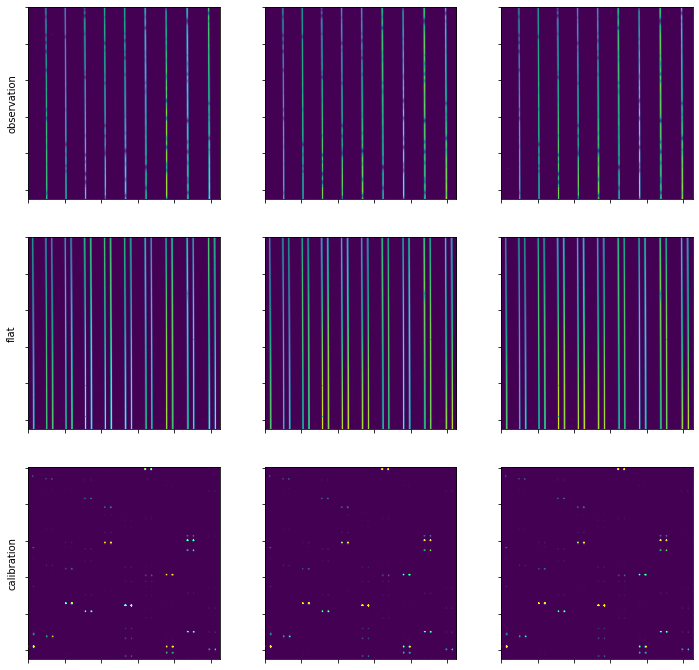

In [120]:
j_num = 3
fig, axes = plt.subplots(3,j_num,figsize=(12,12),edgecolor=(0,0,0))

some_step = 10
for j in range(some_step,some_step+j_num):
#     axes[0,j].set_title()
    for iii in range(3):
        np_arr = np.array(ds['images'][ref_arr[j][iii]]['hdu_1'])
#         axes[iii,j].set_title(at.Time(ref_arr[j][iii].split('HARPS.')[1]))
        axes[iii,j % axes.shape[1]].imshow(np_arr)
        axes[iii,j % axes.shape[1]].set_yticklabels([])
        axes[iii,j % axes.shape[1]].set_xticklabels([])
        
axes[0,0].set_ylabel('observation')
axes[1,0].set_ylabel('flat')
axes[2,0].set_ylabel('calibration')
plt.show()

In [116]:
for x in ref_arr:
    print(x)

['HARPS.2013-06-08T08:04:03.052', 'HARPS.2013-06-07T21:22:04.297', 'HARPS.2013-06-07T21:09:49.773']
['HARPS.2013-06-08T08:11:35.239', 'HARPS.2013-06-07T21:22:04.297', 'HARPS.2013-06-07T21:09:49.773']
['HARPS.2013-06-08T08:19:06.826', 'HARPS.2013-06-07T21:22:04.297', 'HARPS.2013-06-08T19:25:04.960']
['HARPS.2013-06-25T06:50:16.144', 'HARPS.2013-06-24T19:50:15.122', 'HARPS.2013-06-24T21:23:15.021']
['HARPS.2013-06-25T06:59:57.608', 'HARPS.2013-06-24T19:50:15.122', 'HARPS.2013-06-24T21:23:15.021']
['HARPS.2013-06-25T07:11:54.202', 'HARPS.2013-06-24T19:50:15.122', 'HARPS.2013-06-24T21:23:15.021']
['HARPS.2013-06-25T07:22:47.000', 'HARPS.2013-06-24T19:50:15.122', 'HARPS.2013-06-24T21:23:15.021']
['HARPS.2013-06-25T09:52:03.446', 'HARPS.2013-06-25T19:06:19.089', 'HARPS.2013-06-25T19:10:15.003']
['HARPS.2013-06-25T10:01:32.831', 'HARPS.2013-06-25T19:06:19.089', 'HARPS.2013-06-25T19:10:15.003']
['HARPS.2013-06-25T10:11:00.055', 'HARPS.2013-06-25T19:06:19.089', 'HARPS.2013-06-25T19:10:15.003']
